Loaded 31 non-forest files and 45 forest files.
Combined feature matrix shape: (760000, 3), Labels shape: (760000,)
Training set shape: (532000, 3)
Validation set shape: (114000, 3)
Test set shape: (114000, 3)
Training Set Evaluation:
Adjusted Rand Index: 0.4542
Accuracy: 0.8380
Validation Set Evaluation:
Adjusted Rand Index: 0.4559
Accuracy: 0.8386
Test Set Evaluation:
Adjusted Rand Index: 0.4533
Accuracy: 0.8376


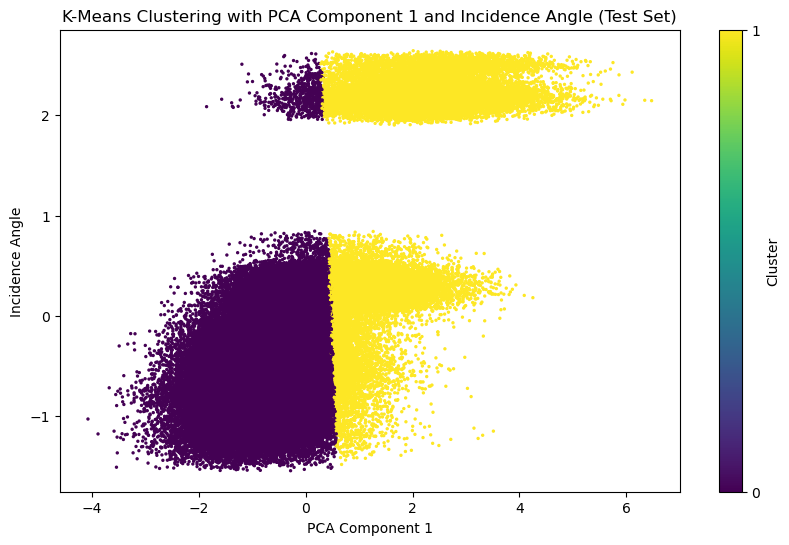

In [19]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, accuracy_score

# Data Loading and Preprocessing

def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the three bands (VV, VH, Incidence Angle).
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read([1, 2, 3])  # Load bands 1, 2, and 3 (VV, VH, Incidence Angle)
            bands_list.append(bands)
    
    return bands_list

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all data files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")

# Function to extract random non-NaN pixels
def extract_random_pixels(data, num_pixels=10000):
    """
    Extract a specified number of random non-NaN pixels from the data.
    """
    pixels = []

    for bands in data:
        h, w = bands.shape[1], bands.shape[2]
        # Flatten the data for easier access to pixels
        flat_pixels = bands.reshape(3, h * w).T  # Shape: (h*w, 3)
        valid_pixels = flat_pixels[~np.isnan(flat_pixels).any(axis=1)]  # Filter out NaN pixels
        
        if valid_pixels.shape[0] >= num_pixels:
            # Randomly sample the required number of pixels
            sampled_pixels = valid_pixels[np.random.choice(valid_pixels.shape[0], num_pixels, replace=False)]
            pixels.append(sampled_pixels)
        else:
            # If not enough valid pixels, sample all available
            pixels.append(valid_pixels)
    
    return np.vstack(pixels)

# Extract 10,000 random pixels from each class (forest and non-forest)
non_forest_pixels = extract_random_pixels(non_forest_data, num_pixels=10000)
forest_pixels = extract_random_pixels(forest_data, num_pixels=10000)

# Combine and label the data
X = np.vstack([non_forest_pixels, forest_pixels])
y = np.hstack([np.zeros(non_forest_pixels.shape[0]), np.ones(forest_pixels.shape[0])])

print(f"Combined feature matrix shape: {X.shape}, Labels shape: {y.shape}")

# # Normalize the features
# scaler = StandardScaler()
# X_norm = scaler.fit_transform(X)

# Step 1: Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Step 2: Train the K-Means Model on the Training Set
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)
train_clusters = kmeans.predict(X_train)

# Step 3: Validate the Model
val_clusters = kmeans.predict(X_val)

# Step 4: Test the Model
test_clusters = kmeans.predict(X_test)

# Evaluation: Compare Clusters to True Labels
def evaluate_clustering(y_true, clusters):
    # Since K-Means doesn't produce labeled clusters, we use adjusted_rand_score
    # to measure the similarity between two clusterings.
    ari = adjusted_rand_score(y_true, clusters)
    print(f"Adjusted Rand Index: {ari:.4f}")
    
    # Alternatively, if the clusters are binary, you can check accuracy assuming
    # labels are aligned. 
    accuracy = max(accuracy_score(y_true, clusters), accuracy_score(y_true, 1 - clusters))
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate on Training Set
print("Training Set Evaluation:")
evaluate_clustering(y_train, train_clusters)

# Evaluate on Validation Set
print("Validation Set Evaluation:")
evaluate_clustering(y_val, val_clusters)

# Evaluate on Test Set
print("Test Set Evaluation:")
evaluate_clustering(y_test, test_clusters)

# Optional: Visualize the test set with PCA and the third band (Incidence Angle)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Optional: Visualize the test set with PCA and the third band (Incidence Angle)
plt.figure(figsize=(10, 6))

# Create a scatter plot with binary labels for clusters
scatter = plt.scatter(X_test_pca[:, 0], X_test[:, 2], c=test_clusters, cmap='viridis', s=2)

# Set the colorbar to only show binary values 0 and 1
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.set_label("Cluster")
cbar.set_ticks([0, 1])

plt.title("K-Means Clustering with PCA Component 1 and Incidence Angle (Test Set)")
plt.xlabel("PCA Component 1")
plt.ylabel("Incidence Angle")
plt.show()



In [3]:
# Visualizing the Metrics
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(metrics_df['Model'], metrics_df[f'{metric} (Non-Forest)'], color='skyblue', label=f'{metric} (Non-Forest)')
    axes[idx].bar(metrics_df['Model'], metrics_df[f'{metric} (Forest)'], color='lightgreen', label=f'{metric} (Forest)', bottom=metrics_df[f'{metric} (Non-Forest)'])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Save the selected classifier

# Assuming svm_classifier is your trained SVM model
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl'
joblib.dump(svm_classifier, model_path)
print(f"SVM model saved to {model_path}")

# Save the fitted scaler to a file
scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

C:\Users\raznu\AppData\Local\Temp\ipykernel_5512\559791699.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(time_series_data)


ValueError: could not broadcast input array from shape (3,110,211) into shape (3,)